In [84]:
import numpy as np
import pandas as pd
from functions import loadMultiParquet, cut
from helpersForNN import preprocessMultiClass, scale, unscale
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import mplhep as hep
hep.style.use("CMS")
import sys, os, glob, re
import math
from applyMultiClass_Hpeak import getPredictions, splitPtFunc

In [85]:
pTClass, nReal, nMC = 0, 800, -1
paths = [
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/Data1A/others",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/GluGluHToBB/others",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-100to200",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-200to400",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-400to600",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-600to800",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-800toInf"
            ]

pathToPredictions = "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/NNpredictions"
# check for which fileNumbers the predictions is available
isMCList = [0, 1,36, 20, 21, 22, 23]
fileNumberList = []
for isMC in isMCList:
    fileNumberProcess = []
    fileNamesProcess = glob.glob(pathToPredictions+"/yMC%d_fn*pt%d*.parquet"%(isMC, pTClass))
    for fileName in fileNamesProcess:
        match = re.search(r'_fn(\d+)_pt', fileName)
        if match:
            fn = match.group(1)
            fileNumberProcess.append(int(fn))
            
        else:
            pass
            #print("Number not found")
    fileNumberList.append(fileNumberProcess)
    print(len(fileNumberProcess), " predictions files for process MC : ", isMC)


# load the files where the prediction is available
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=-1, columns=['sf', 'dijet_mass', 'dijet_pt', 'jet1_pt', 'jet2_pt','jet1_mass', 'jet2_mass', 'jet1_eta', 'jet2_eta', 'jet1_qgl', 'jet2_qgl'], returnNumEventsTotal=True, selectFileNumberList=fileNumberList, returnFileNumberList=True)
pTmin, pTmax, suffix = [[0,-1,'inclusive'], [0, 30, 'lowPt'], [30, 100, 'mediumPt'], [100, -1, 'highPt']][pTClass]    
dfs = preprocessMultiClass(dfs, pTmin, pTmax, suffix)   # get the dfs with the cut in the pt class


1009  predictions files for process MC :  0
154  predictions files for process MC :  1
1623  predictions files for process MC :  36
162  predictions files for process MC :  20
249  predictions files for process MC :  21
241  predictions files for process MC :  22
209  predictions files for process MC :  23
process 0 from dfs:  1000
800 files for process 0


process 1 from dfs:  154
154 files for process 1


process 2 from dfs:  1623
1623 files for process 2


process 3 from dfs:  162
162 files for process 3


process 4 from dfs:  249
249 files for process 4


process 5 from dfs:  241
241 files for process 5


process 6 from dfs:  209
209 files for process 6


Preprocessing...
Performing the cut in pt and eta
Pt cut class applied 0--1
Nan values : 17 process 0 
Filling jet1 qgl with 0. 2
Filling jet2 qgl with 0. 15 

Pt cut class applied 0--1
Filling jet1 qgl with 0. 0
Filling jet2 qgl with 0. 0 

Pt cut class applied 0--1
Filling jet1 qgl with 0. 0
Filling jet2 qgl with 0. 0 

Pt cut c

In [86]:
minPt, maxPt = None, None #180, -1
if (minPt is not None) | (maxPt is not None):
    dfs, masks = splitPtFunc(dfs, minPt, maxPt)
    splitPt = True
else:
    masks=None
    splitPt=False
        
W = dfs[0].sf
W_H = dfs[1].sf
W_1 = 5.261e+03/numEventsList[2]*dfs[2].sf*nReal*0.774/1017*1000
W_2 = 1012./numEventsList[3]*dfs[3].sf*nReal*0.774/1017*1000
W_3 = 114.2/numEventsList[4]*dfs[4].sf*nReal*0.774/1017*1000
W_4 = 25.34/numEventsList[5]*dfs[5].sf*nReal*0.774/1017*1000
W_5 = 12.99/numEventsList[6]*dfs[6].sf*nReal*0.774/1017*1000
dfs = [dfs[0], dfs[1], pd.concat(dfs[2:])]

W_Z = np.concatenate([W_1, W_2, W_3, W_4, W_5])

In [87]:
YPred_data, YPred_H, YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf = getPredictions(fileNumberList, pathToPredictions, splitPt=splitPt, masks=masks, isMC=isMCList, pTClass=pTClass)
YPred_Z = np.concatenate((YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf))

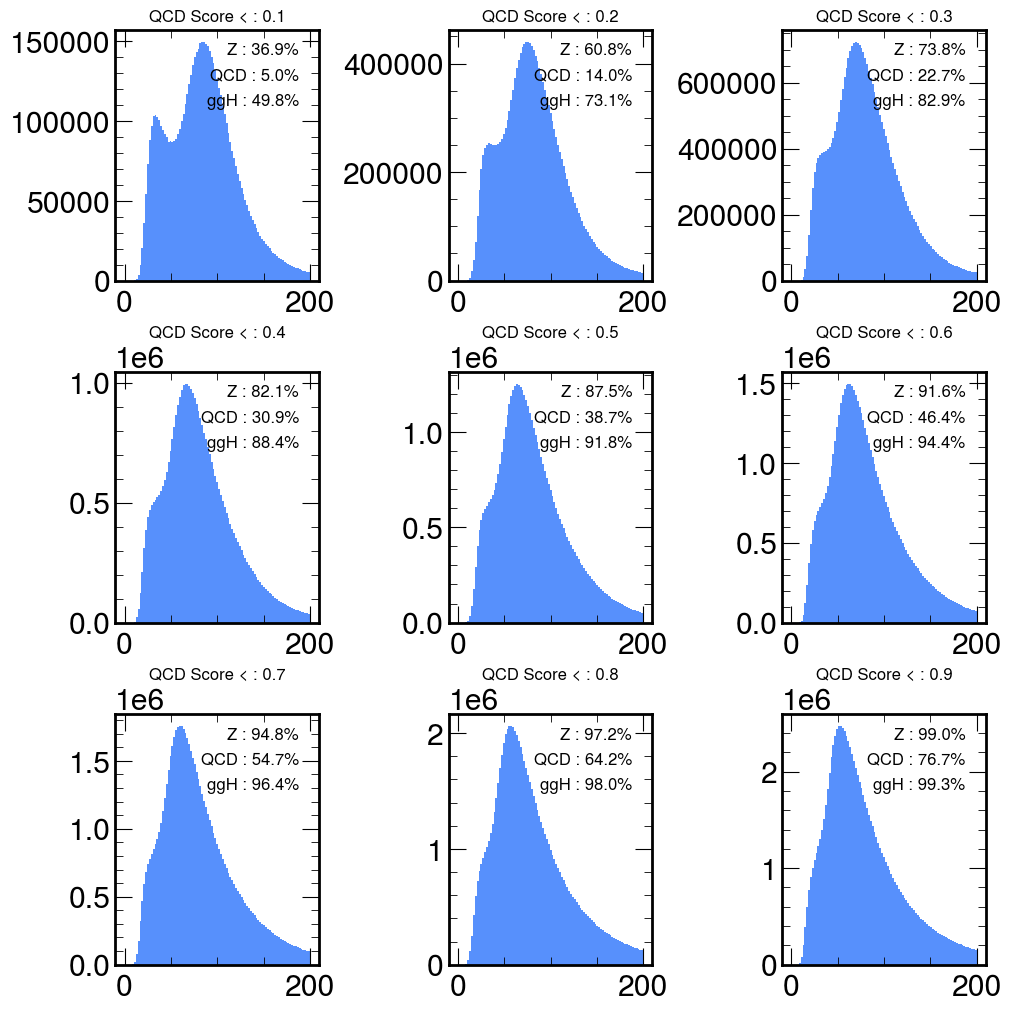

In [88]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,0]<t[i*ncols+j]
        mask_Z = YPred_Z[:,0]<t[i*ncols+j]
        mask_H = YPred_H[:,0]<t[i*ncols+j]
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_title("QCD Score < : %.1f"%(t[i*ncols+j]), fontsize=12)


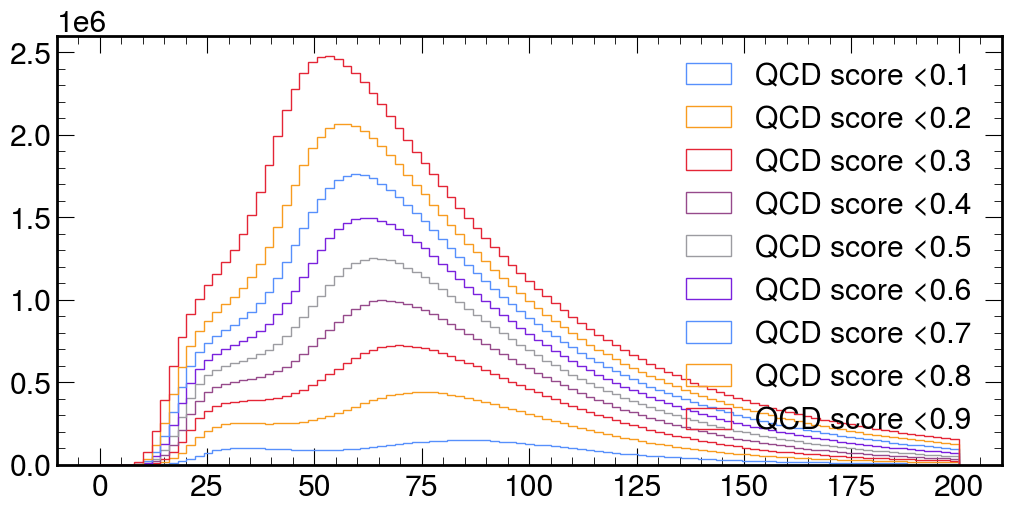

In [89]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,0]<t[i*ncols+j]
        mask_Z = YPred_Z[:,0]<t[i*ncols+j]
        mask_H = YPred_H[:,0]<t[i*ncols+j]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data], label='QCD score <%.1f'%t[i*ncols+j], histtype=u'step')[0]
        #ax.text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(mask_Z)/len(mask_Z)*100), transform=ax.transAxes, fontsize=12, ha='right')
        #ax.text(x=0.9, y=0.8, s="QCD : %.1f%%"%(np.sum(mask_data)/len(mask_data)*100), transform=ax.transAxes, fontsize=12, ha='right')
        #ax.text(x=0.9, y=0.7, s="ggH : %.1f%%"%(np.sum(mask_H)/len(mask_H)*100), transform=ax.transAxes, fontsize=12, ha='right')
        #ax.set_title("QCD Score < : %.1f"%(t[i*ncols+j]), fontsize=12)
ax.legend()

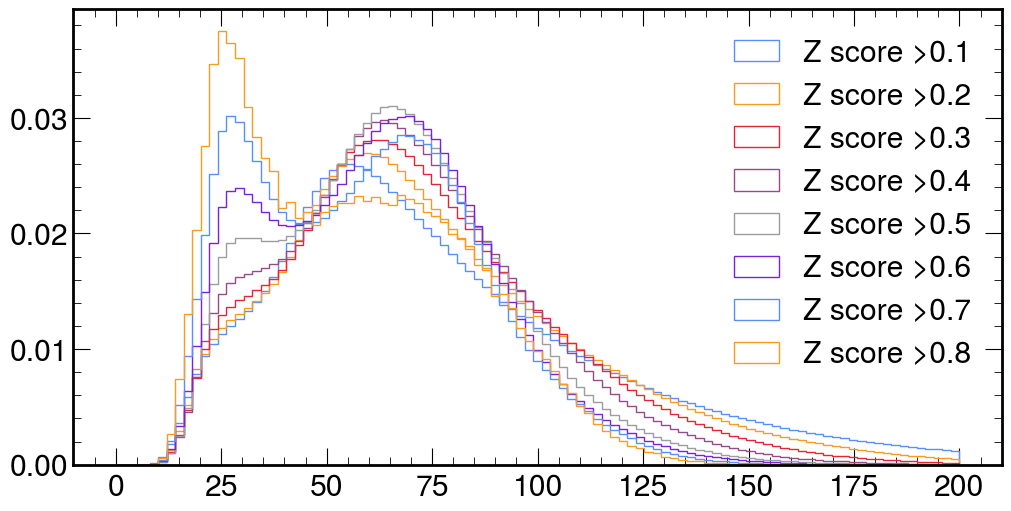

In [90]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for i in range(len(t)):
        mask_data = YPred_data[:,2]>t[i]
        mask_Z = YPred_Z[:,2]>t[i]
        mask_H = YPred_H[:,2]>t[i]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/np.sum(dfs[0].sf[mask_data]), label='Z score >%.1f'%t[i], histtype=u'step')[0]
        #ax.text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(mask_Z)/len(mask_Z)*100), transform=ax.transAxes, fontsize=12, ha='right')
        #ax.text(x=0.9, y=0.8, s="QCD : %.1f%%"%(np.sum(mask_data)/len(mask_data)*100), transform=ax.transAxes, fontsize=12, ha='right')
        #ax.text(x=0.9, y=0.7, s="ggH : %.1f%%"%(np.sum(mask_H)/len(mask_H)*100), transform=ax.transAxes, fontsize=12, ha='right')
        #ax.set_title("QCD Score < : %.1f"%(t[i]), fontsize=12)
ax.legend()

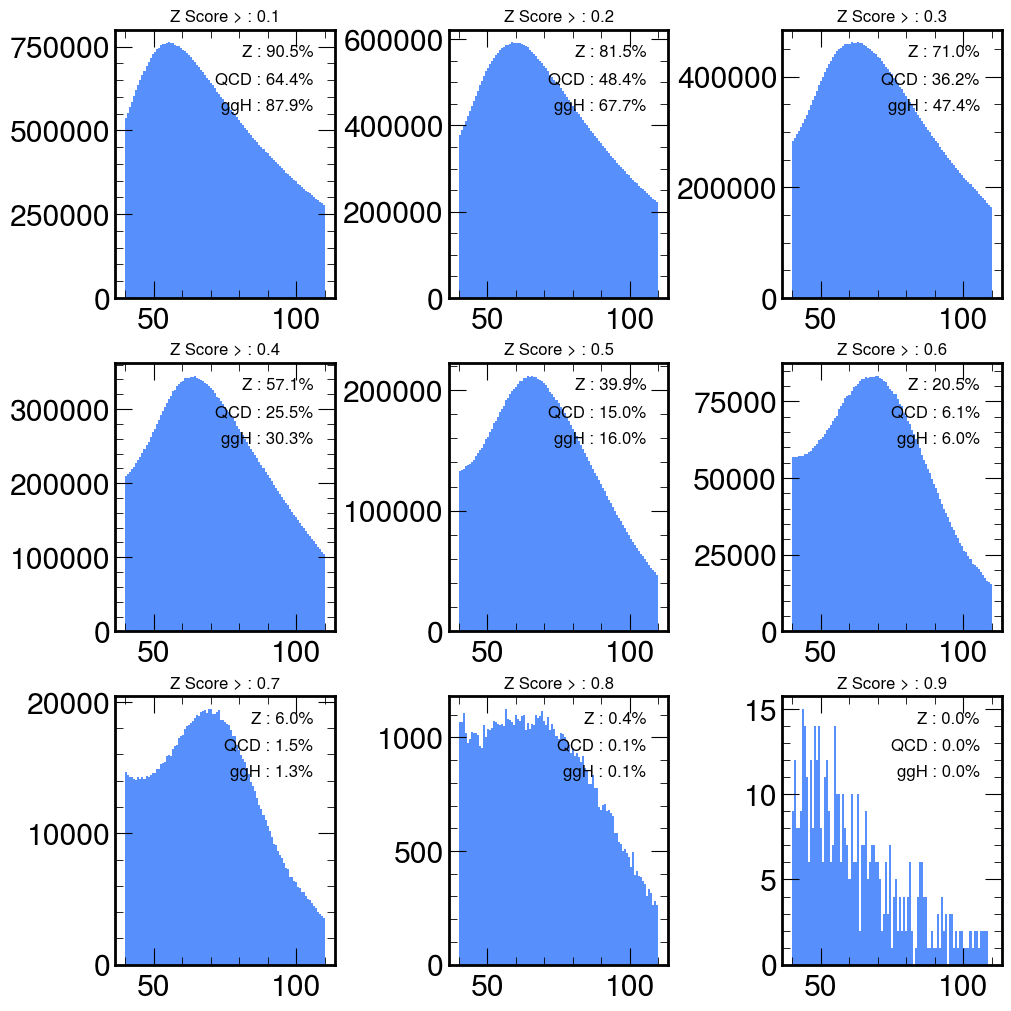

In [91]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(40, 110, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):

        mask_data = YPred_data[:,2]>t[i*ncols+j]
        mask_Z = YPred_Z[:,2]>t[i*ncols+j]
        mask_H = YPred_H[:,2]>t[i*ncols+j]
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]

        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_title("Z Score > : %.1f"%(t[i*ncols+j]), fontsize=12)
